In [42]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier 
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import mlflow
import optuna

from scipy.stats import levene
from scipy.stats import f_oneway
from pingouin import welch_anova
from pingouin import pairwise_gameshowell

from matplotlib import rc
plt.rcParams['axes.unicode_minus'] = False
rc('font', family='Malgun Gothic')
%matplotlib inline

In [43]:
st = StandardScaler()

knn_model = joblib.load("./model/knn_best_model.h5")

df_model = pd.read_csv("./Dataset/train_preprocessing.csv")
df_model.drop(columns="Unnamed: 0", inplace=True)

x = df_model.drop(columns=["신용점수"])
y = df_model['신용점수']

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=13)
x_valid_drop = x_valid.drop(columns="고객ID")
x_valid_drop.shape
le = LabelEncoder()
y_valid_le = le.fit_transform(y_valid)
x_valid_drop_scale = st.fit_transform(x_valid_drop)

y_pred = knn_model.predict(x_valid_drop_scale)
print(accuracy_score(y_valid, y_pred))
print(confusion_matrix(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

0.79765
[[2786   45  795]
 [ 143 4745  902]
 [ 901 1261 8422]]
              precision    recall  f1-score   support

        Good       0.73      0.77      0.75      3626
        Poor       0.78      0.82      0.80      5790
    Standard       0.83      0.80      0.81     10584

    accuracy                           0.80     20000
   macro avg       0.78      0.79      0.79     20000
weighted avg       0.80      0.80      0.80     20000



In [44]:
df = pd.read_csv("./Dataset/eda_data.csv")
df

,고객ID,월,나이,직업,연수입,월급,계좌 수,신용카드 수,이자율,대출수,...,AutoLoan,Credit-BuilderLoan,PersonalLoan,HomeEquityLoan,NotSpecified,None,MortgageLoan,StudentLoan,DebtConsolidationLoan,PaydayLoan
0,CUS_0xd40,1,23,Scientist,19114.12,1824.843333,3.0,4.0,3,4,...,1,1,1,1,0,0,0,0,0,0
1,CUS_0xd40,2,23,Scientist,19114.12,1824.843333,3.0,4.0,3,4,...,1,1,1,1,0,0,0,0,0,0
2,CUS_0xd40,3,23,Scientist,19114.12,1824.843333,3.0,4.0,3,4,...,1,1,1,1,0,0,0,0,0,0
3,CUS_0xd40,4,23,Scientist,19114.12,1824.843333,3.0,4.0,3,4,...,1,1,1,1,0,0,0,0,0,0
4,CUS_0xd40,5,23,Scientist,19114.12,1824.843333,3.0,4.0,3,4,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,CUS_0x942c,4,25,Mechanic,39628.99,3359.415833,4.0,6.0,7,2,...,1,0,0,0,0,0,0,1,0,0
99996,CUS_0x942c,5,25,Mechanic,39628.99,3359.415833,4.0,6.0,7,2,...,1,0,0,0,0,0,0,1,0,0
99997,CUS_0x942c,6,25,Mechanic,39628.99,3359.415833,4.0,6.0,7,2,...,1,0,0,0,0,0,0,1,0,0
99998,CUS_0x942c,7,25,Mechanic,39628.99,3359.415833,4.0,6.0,7,2,...,1,0,0,0,0,0,0,1,0,0


In [45]:
def get_age_group(age):
    if age < 20:
        return '10대'
    elif age < 30:
        return '20대'
    elif age < 40:
        return '30대'
    elif age < 50:
        return '40대'
    else:
        return '50대'
# '연령대' 열 추가
df['연령대'] = df['나이'].apply(get_age_group)
df['연령대'].value_counts()

30대    29085
20대    28826
40대    22383
10대    11177
50대     8529
Name: 연령대, dtype: int64

<AxesSubplot: xlabel='신용점수', ylabel='계좌 수'>

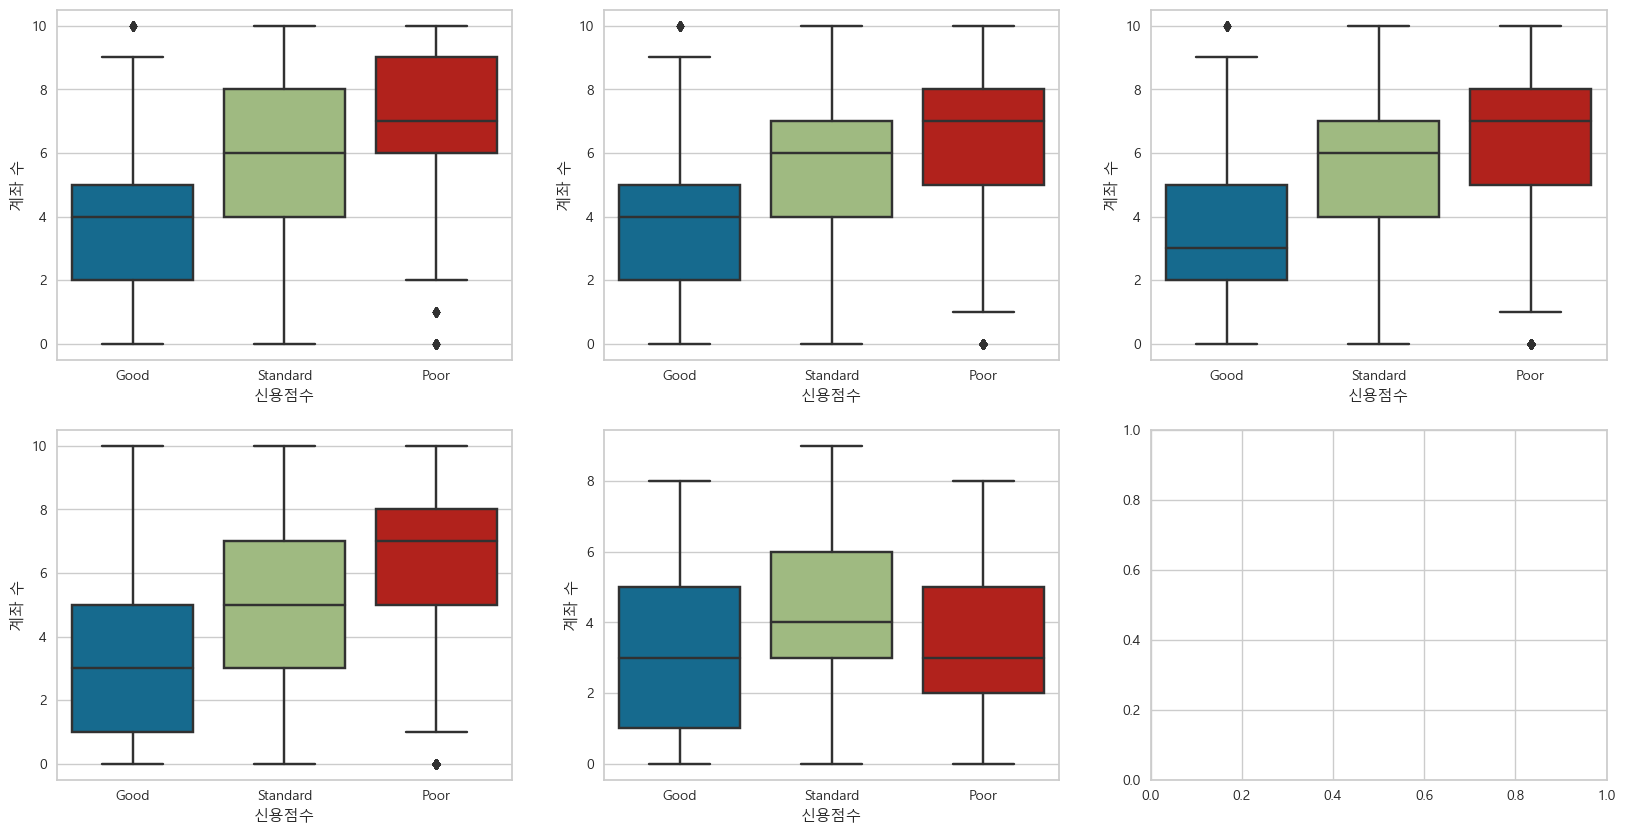

In [46]:
# 나이에 따른, 신용등급에 따른, 월별 투자금액
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (20, 10))

sns.boxplot(df[df['연령대'] == '10대'], x = '신용점수', y = '계좌 수', ax = ax[0, 0], order = ['Good', 'Standard', 'Poor'])
sns.boxplot(df[df['연령대'] == '20대'], x = '신용점수', y = '계좌 수', ax = ax[0, 1], order = ['Good', 'Standard', 'Poor'])
sns.boxplot(df[df['연령대'] == '30대'], x = '신용점수', y = '계좌 수', ax = ax[0, 2], order = ['Good', 'Standard', 'Poor'])
sns.boxplot(df[df['연령대'] == '40대'], x = '신용점수', y = '계좌 수', ax = ax[1, 0], order = ['Good', 'Standard', 'Poor'])
sns.boxplot(df[df['연령대'] == '50대'], x = '신용점수', y = '계좌 수', ax = ax[1, 1], order = ['Good', 'Standard', 'Poor'])

<AxesSubplot: xlabel='신용점수', ylabel='계좌 수'>

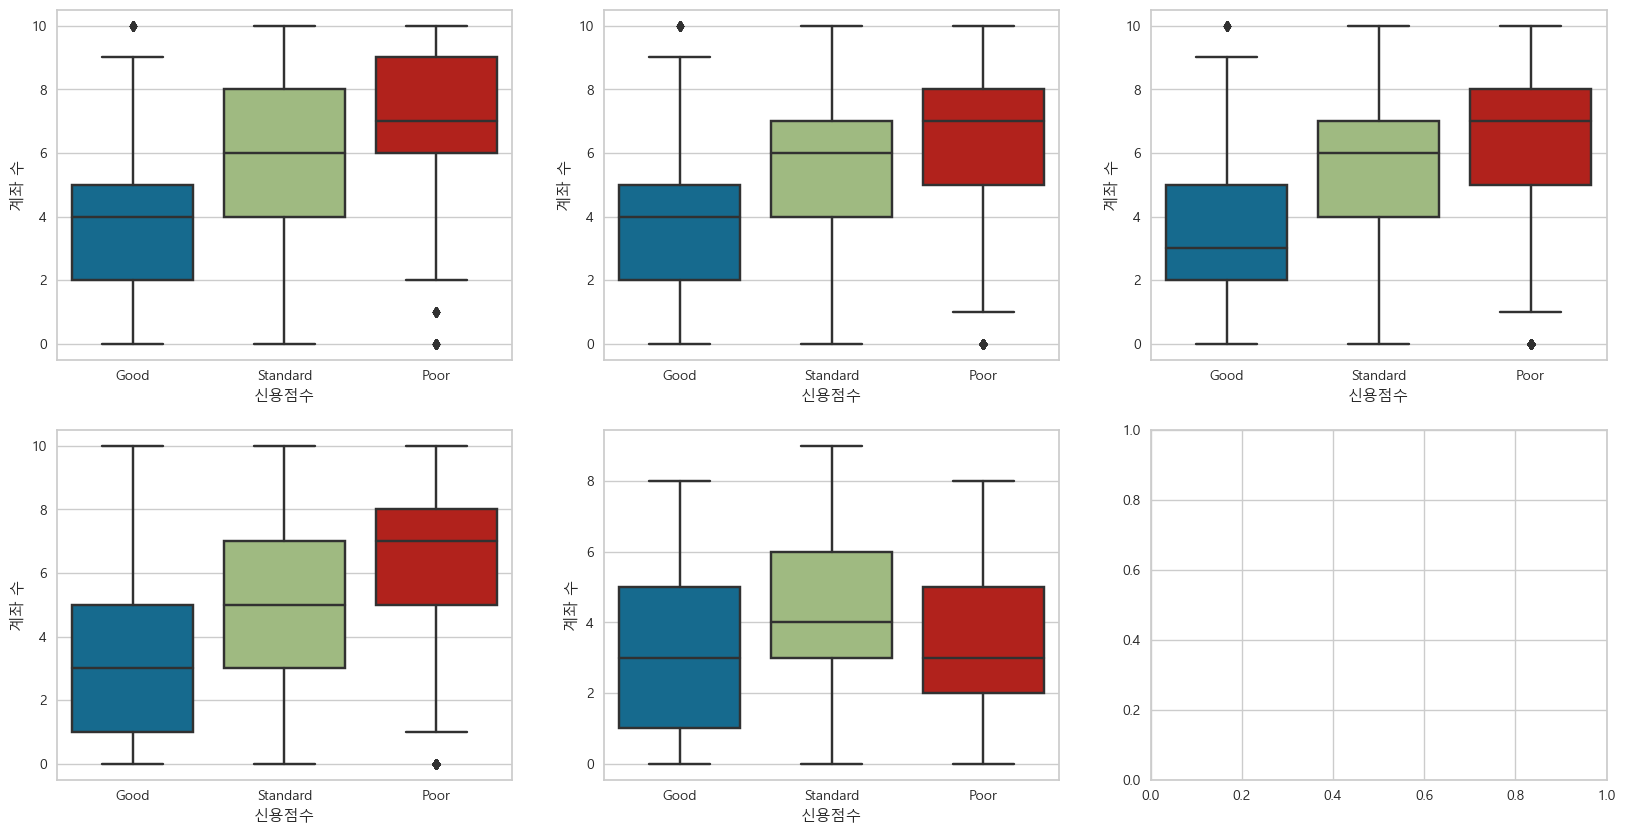

In [47]:
# 나이에 따른, 신용등급에 따른, 월별 투자금액
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (20, 10))

sns.boxplot(df[df['연령대'] == '10대'], x = '신용점수', y = '계좌 수', ax = ax[0, 0], order = ['Good', 'Standard', 'Poor'])
sns.boxplot(df[df['연령대'] == '20대'], x = '신용점수', y = '계좌 수', ax = ax[0, 1], order = ['Good', 'Standard', 'Poor'])
sns.boxplot(df[df['연령대'] == '30대'], x = '신용점수', y = '계좌 수', ax = ax[0, 2], order = ['Good', 'Standard', 'Poor'])
sns.boxplot(df[df['연령대'] == '40대'], x = '신용점수', y = '계좌 수', ax = ax[1, 0], order = ['Good', 'Standard', 'Poor'])
sns.boxplot(df[df['연령대'] == '50대'], x = '신용점수', y = '계좌 수', ax = ax[1, 1], order = ['Good', 'Standard', 'Poor'])

<AxesSubplot: xlabel='신용점수', ylabel='이자율'>

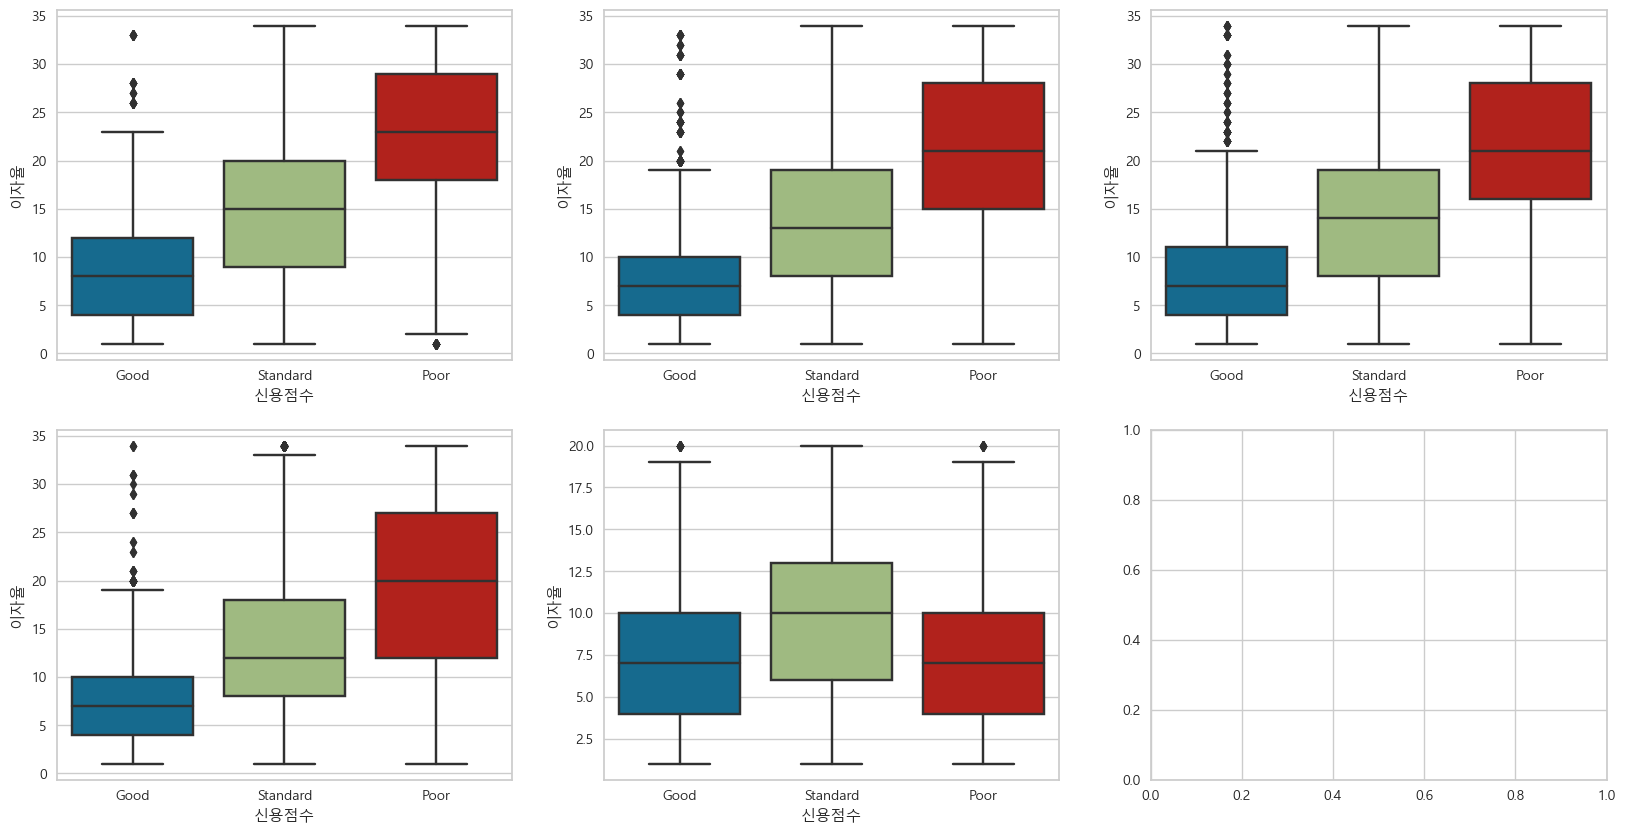

In [48]:
# 나이에 따른, 신용등급에 따른, 월별 투자금액
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (20, 10))

sns.boxplot(df[df['연령대'] == '10대'], x = '신용점수', y = '이자율', ax = ax[0, 0], order = ['Good', 'Standard', 'Poor'])
sns.boxplot(df[df['연령대'] == '20대'], x = '신용점수', y = '이자율', ax = ax[0, 1], order = ['Good', 'Standard', 'Poor'])
sns.boxplot(df[df['연령대'] == '30대'], x = '신용점수', y = '이자율', ax = ax[0, 2], order = ['Good', 'Standard', 'Poor'])
sns.boxplot(df[df['연령대'] == '40대'], x = '신용점수', y = '이자율', ax = ax[1, 0], order = ['Good', 'Standard', 'Poor'])
sns.boxplot(df[df['연령대'] == '50대'], x = '신용점수', y = '이자율', ax = ax[1, 1], order = ['Good', 'Standard', 'Poor'])

<AxesSubplot: xlabel='신용점수', ylabel='대출수'>

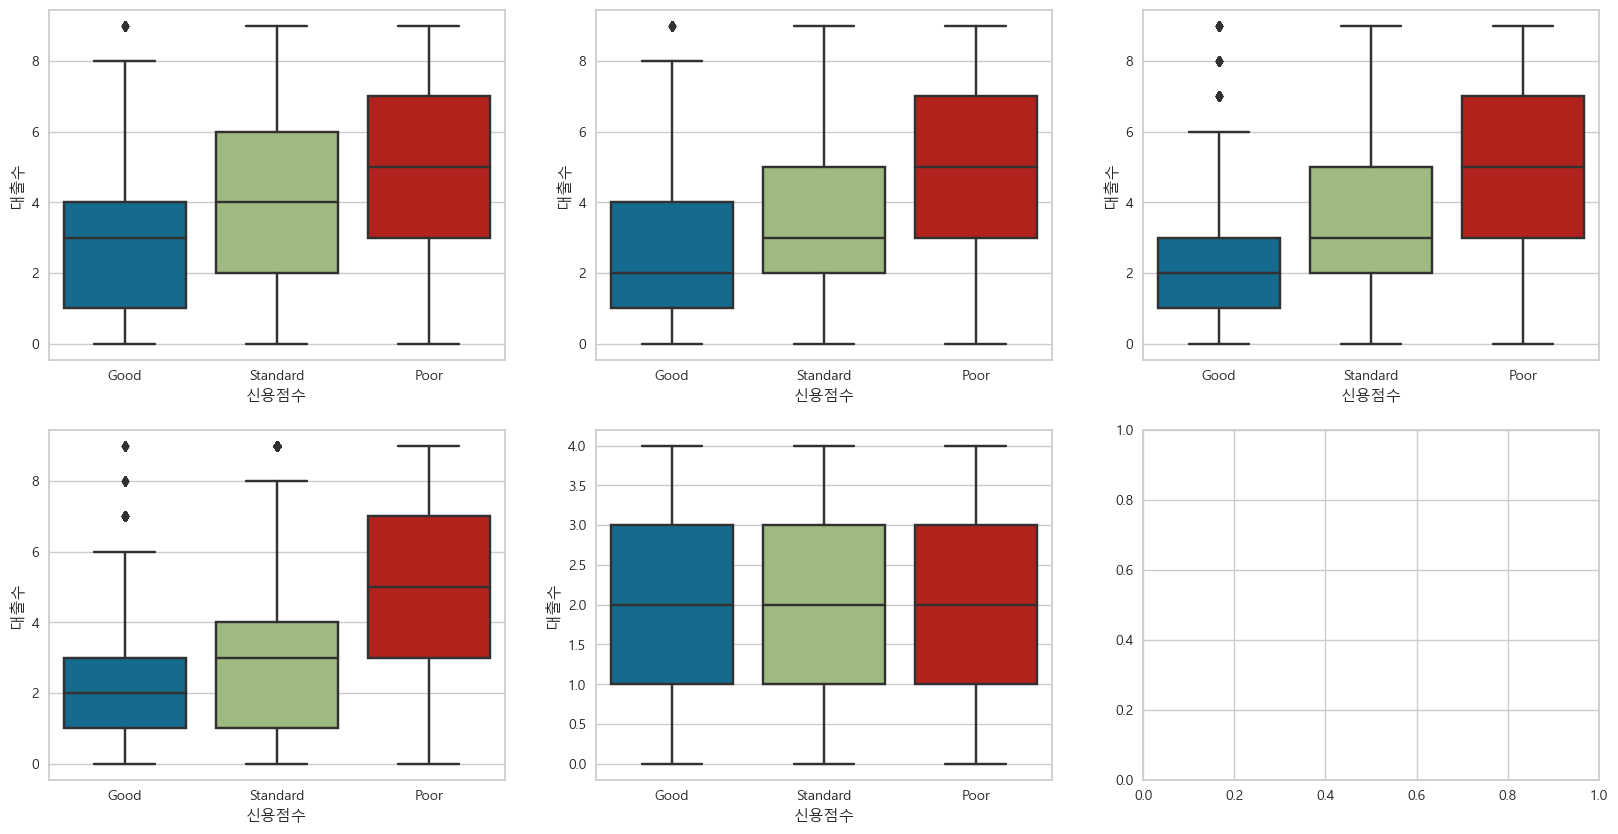

In [49]:
# 나이에 따른, 신용등급에 따른, 월별 투자금액
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (20, 10))

sns.boxplot(df[df['연령대'] == '10대'], x = '신용점수', y = '대출수', ax = ax[0, 0], order = ['Good', 'Standard', 'Poor'])
sns.boxplot(df[df['연령대'] == '20대'], x = '신용점수', y = '대출수', ax = ax[0, 1], order = ['Good', 'Standard', 'Poor'])
sns.boxplot(df[df['연령대'] == '30대'], x = '신용점수', y = '대출수', ax = ax[0, 2], order = ['Good', 'Standard', 'Poor'])
sns.boxplot(df[df['연령대'] == '40대'], x = '신용점수', y = '대출수', ax = ax[1, 0], order = ['Good', 'Standard', 'Poor'])
sns.boxplot(df[df['연령대'] == '50대'], x = '신용점수', y = '대출수', ax = ax[1, 1], order = ['Good', 'Standard', 'Poor'])

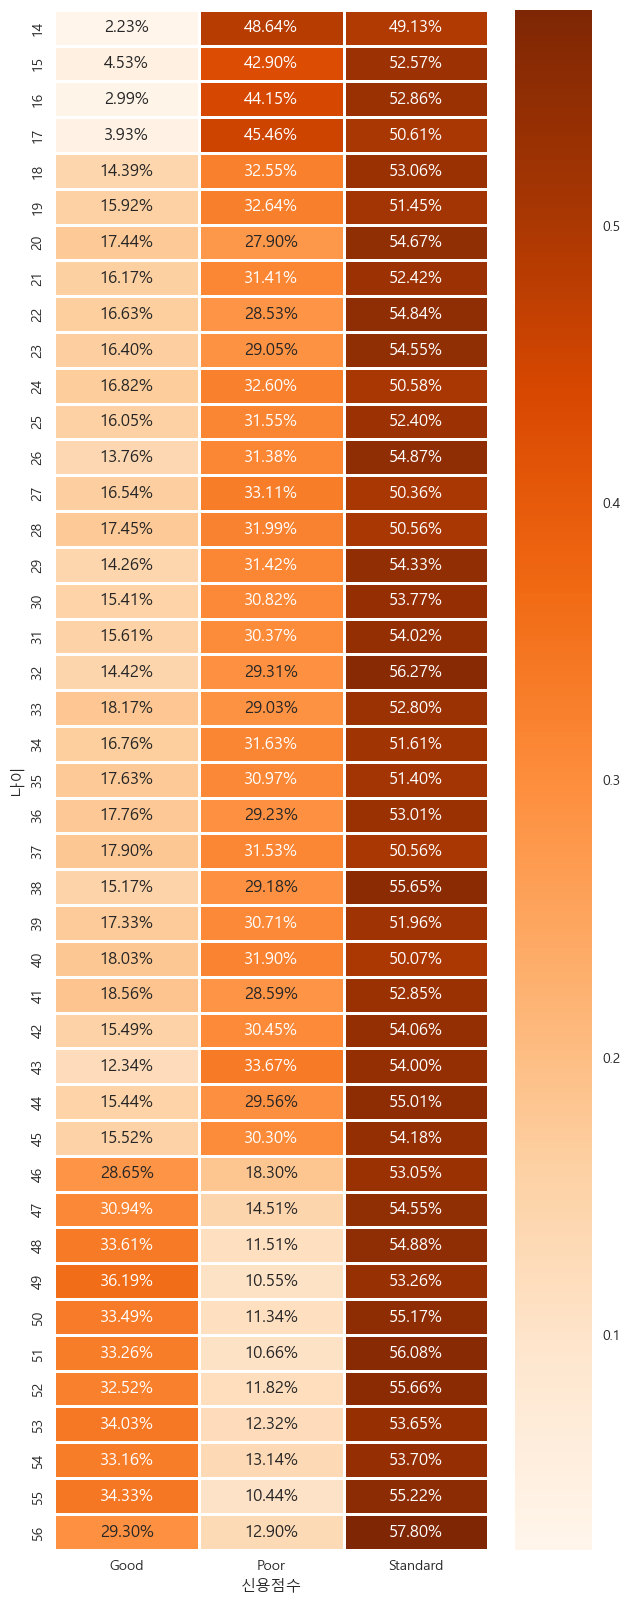

In [50]:
# 피봇 테이블
table = df.pivot_table(index = '나이', columns = '신용점수', aggfunc = 'size')
pivot_table_ratio = table.div(table.sum(axis=1), axis=0)
pivot_table_ratio
# 히트맵
plt.figure(figsize = (7, 20))
sns.heatmap(pivot_table_ratio,
            annot = True,     # 데이터 값 표시 여부
            fmt = '.2%',        # 숫자 표현 방식 지정 (d: 정수)
            cmap = 'Oranges', # 컬러맵
            linewidth = 1,    # 구분 선
            cbar = True)      # 컬러바 표시 여부
plt.show()

## 소비금액

In [51]:
df['소비금액'] = df['월급'] - df['월별 할부 지불액'] - df['월별 투자금액'] - df['월별 고객 잔액']

In [52]:
group1 = df[df['신용점수'] == "Poor"]['소비금액']
group2 = df[df['신용점수'] == "Standard"]['소비금액']
group3 = df[df['신용점수'] == "Good"]['소비금액']

levene(group1, group2, group3) # 이분산 가정

LeveneResult(statistic=1224.594906548616, pvalue=0.0)

In [53]:
group_data = pd.DataFrame({
    'group': ['Poor'] * len(group1) + ['Standard'] * len(group2) + ['Good'] * len(group3),
    'score': list(group1) + list(group2) + list(group3)
})

# Welch's ANOVA 진행
welch_result = welch_anova(data=group_data, dv='score', between='group')
print(welch_result)
# p-value가 0.05보다 적기 때문에 각 그룹별 소비금액의 유의미한 차이가 있다

  Source  ddof1         ddof2            F  p-unc       np2
0  group      2  43465.357493  2147.498951    0.0  0.043237


In [54]:
pairwise_gameshowell(data = group_data, dv = 'score', between = 'group')

# group1과 group3 : 차이가 있다.
# group2와 group3 : 차이가 있다.

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Good,Poor,4550.518452,2766.033188,1784.485263,28.496341,62.621557,29349.834489,0.000000e+00,0.641801
1,Good,Standard,4550.518452,3536.651053,1013.867399,27.607122,36.724850,26989.045754,0.000000e+00,0.344337
2,Poor,Standard,2766.033188,3536.651053,-770.617864,18.638180,-41.346197,67916.758872,2.605671e-11,-0.288173


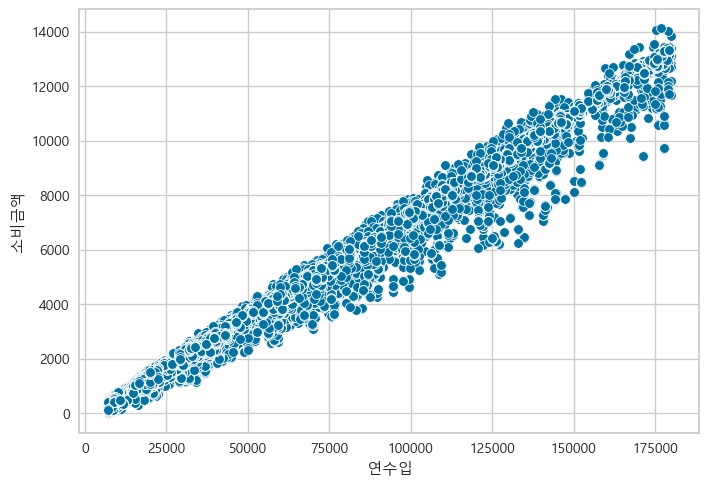

In [55]:
sns.scatterplot(data = df, x = '연수입', y = '소비금액')
plt.show()

## 이자금액

In [56]:
df['이자금액'] = df['남아있는 부채'] * (df['이자율']/100)

In [57]:
group1 = df[df['신용점수'] == "Poor"]['이자금액']
group2 = df[df['신용점수'] == "Standard"]['이자금액']
group3 = df[df['신용점수'] == "Good"]['이자금액']

levene(group1, group2, group3) # 이분산 가정

LeveneResult(statistic=4173.825982408054, pvalue=0.0)

In [58]:
group_data = pd.DataFrame({
    'group': ['Poor'] * len(group1) + ['Standard'] * len(group2) + ['Good'] * len(group3),
    'score': list(group1) + list(group2) + list(group3)
})

# Welch's ANOVA 진행
welch_result = welch_anova(data=group_data, dv='score', between='group')
print(welch_result)
# p-value가 0.05보다 적기 때문에 각 그룹별 소비금액의 유의미한 차이가 있다

  Source  ddof1         ddof2             F  p-unc       np2
0  group      2  58695.643792  17345.878435    0.0  0.179943


In [59]:
pairwise_gameshowell(data = group_data, dv = 'score', between = 'group')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Good,Poor,70.827347,471.625622,-400.798275,2.225445,-180.098075,41057.597883,0.000000e+00,-1.435595
1,Good,Standard,70.827347,228.352245,-157.524898,1.697690,-92.787798,68040.034743,1.087452e-11,-0.556990
2,Poor,Standard,471.625622,228.352245,243.273377,2.421997,100.443284,56337.724709,3.227407e-11,0.747518


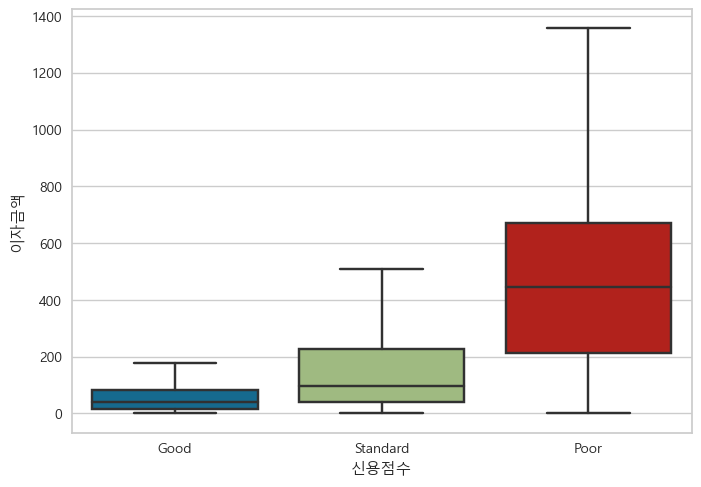

In [60]:
sns.boxplot(data = df, x = '신용점수', y = '이자금액', showfliers = False)
plt.show()

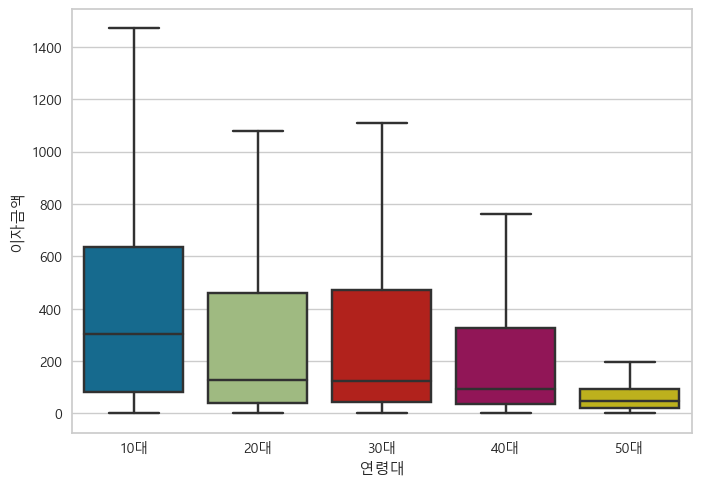

In [61]:
sns.boxplot(data = df, x = '연령대', y = '이자금액', order = ['10대', '20대', '30대', '40대', '50대'], showfliers = False)
plt.show()

## 연체기간

In [62]:
df['연체기간'] = df['연체일수'] * df['연체 지불횟수']

In [63]:
group1 = df[df['신용점수'] == "Poor"]['연체기간']
group2 = df[df['신용점수'] == "Standard"]['연체기간']
group3 = df[df['신용점수'] == "Good"]['연체기간']

levene(group1, group2, group3) # 이분산 가정

LeveneResult(statistic=6336.016627346876, pvalue=0.0)

In [64]:
group_data = pd.DataFrame({
    'group': ['Poor'] * len(group1) + ['Standard'] * len(group2) + ['Good'] * len(group3),
    'score': list(group1) + list(group2) + list(group3)
})

# Welch's ANOVA 진행
welch_result = welch_anova(data=group_data, dv='score', between='group')
print(welch_result)

  Source  ddof1         ddof2             F  p-unc       np2
0  group      2  53936.408299  14896.946715    0.0  0.177788


In [65]:
pairwise_gameshowell(data = group_data, dv = 'score', between = 'group')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Good,Poor,115.472740,515.342058,-399.869319,2.483928,-160.982657,42198.283495,0.000000e+00,-1.292991
1,Good,Standard,115.472740,302.165701,-186.692962,1.676883,-111.333327,55247.900946,3.392253e-11,-0.737906
2,Poor,Standard,515.342058,302.165701,213.176357,2.503514,85.150867,46842.911769,0.000000e+00,0.676459


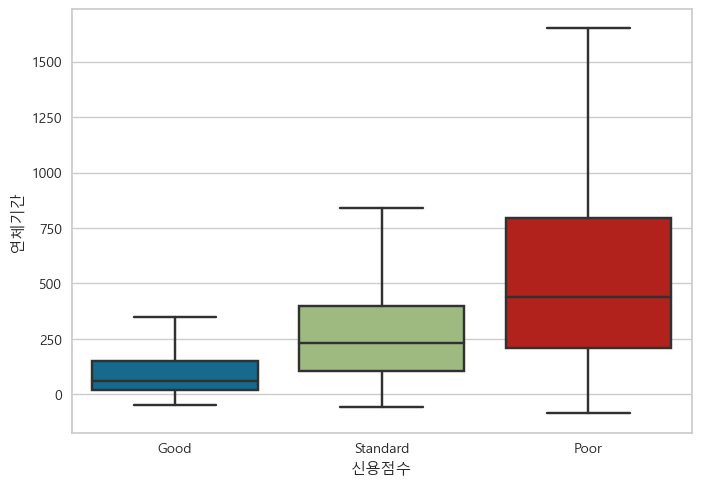

In [66]:
sns.boxplot(data = df, x = '신용점수', y = '연체기간', order = ['Good', 'Standard', 'Poor'], showfliers = False)
plt.show()

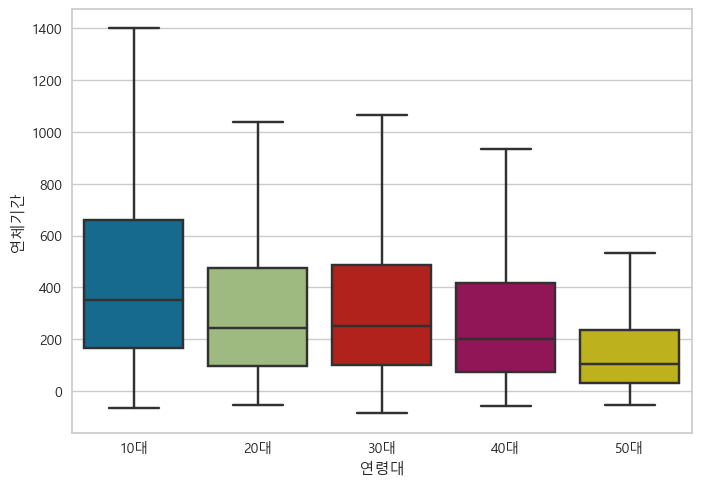

In [67]:
sns.boxplot(data = df, x = '연령대', y = '연체기간', order = ['10대','20대','30대','40대','50대'], showfliers = False)
plt.show()

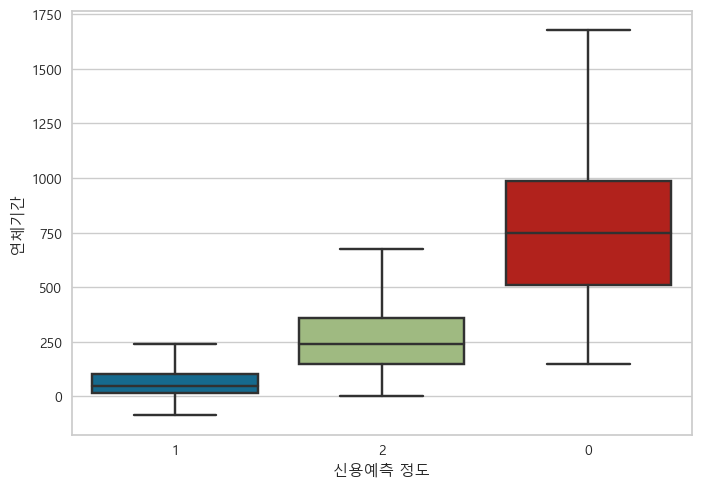

In [68]:
sns.boxplot(data = df, y = '연체기간', x = '신용예측 정도', order = [1, 2, 0], showfliers = False)
plt.show()

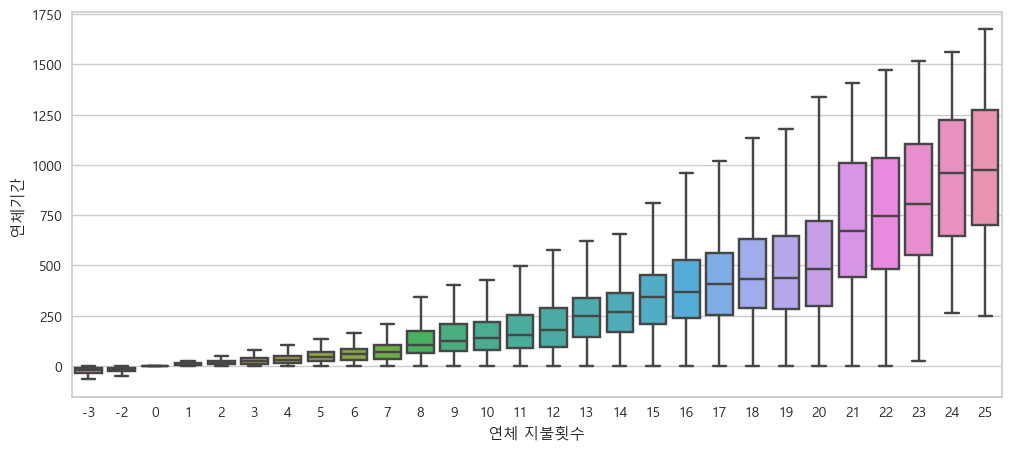

In [69]:
plt.figure(figsize = (12, 5))
sns.boxplot(data = df, x = '연체 지불횟수', y = '연체기간', showfliers = False)
plt.show() 

## 부채 대 소득 비율

In [70]:
df['부채 대 소득 비율'] = df['남아있는 부채'] / df['월급']

In [71]:
group1 = df[df['신용점수'] == "Poor"]['부채 대 소득 비율']
group2 = df[df['신용점수'] == "Standard"]['부채 대 소득 비율']
group3 = df[df['신용점수'] == "Good"]['부채 대 소득 비율']

levene(group1, group2, group3) # 이분산 가정

LeveneResult(statistic=2540.119604082488, pvalue=0.0)

In [72]:
group_data = pd.DataFrame({
    'group': ['Poor'] * len(group1) + ['Standard'] * len(group2) + ['Good'] * len(group3),
    'score': list(group1) + list(group2) + list(group3)
})

# Welch's ANOVA 진행
welch_result = welch_anova(data=group_data, dv='score', between='group')
print(welch_result)

  Source  ddof1        ddof2            F  p-unc       np2
0  group      2  56671.79004  6163.272364    0.0  0.082994


In [73]:
pairwise_gameshowell(data = group_data, dv = 'score', between = 'group')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Good,Poor,0.281884,1.216698,-0.934814,0.008824,-105.945383,40231.021883,0.000000e+00,-0.840170
1,Good,Standard,0.281884,0.645889,-0.364005,0.006003,-60.640127,63697.655272,8.714918e-12,-0.377831
2,Poor,Standard,1.216698,0.645889,0.570809,0.009231,61.835799,49066.568025,1.347089e-11,0.483024


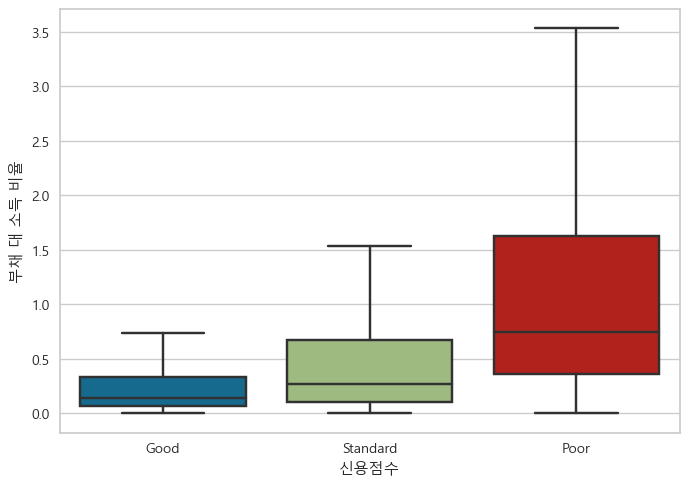

In [74]:
sns.boxplot(data = df, x = '신용점수', y = '부채 대 소득 비율', showfliers = False)
plt.show()

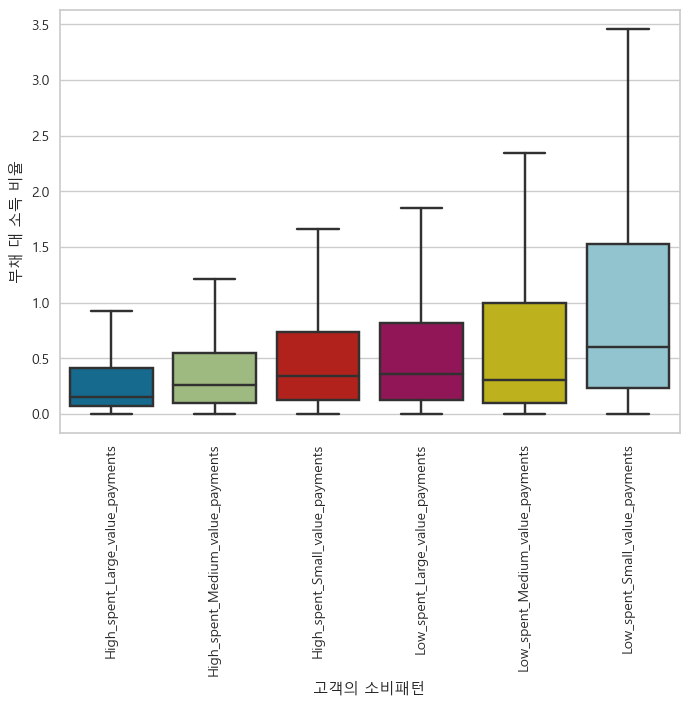

In [75]:
x_order = ['High_spent_Large_value_payments', 'High_spent_Medium_value_payments', 'High_spent_Small_value_payments', 'Low_spent_Large_value_payments', 'Low_spent_Medium_value_payments', 'Low_spent_Small_value_payments']

sns.boxplot(data=df, x='고객의 소비패턴', y='부채 대 소득 비율', showfliers=False, order=x_order)

plt.xticks(rotation=90)
plt.show()

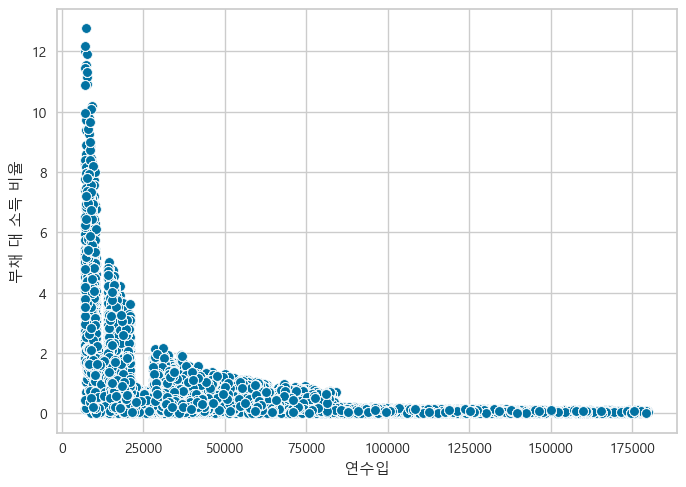

In [76]:
sns.scatterplot(data = df, x = '연수입', y = '부채 대 소득 비율')
plt.show()

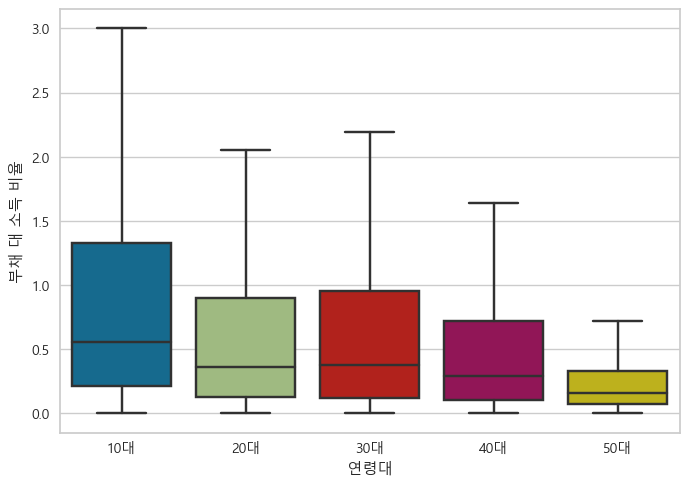

In [77]:
sns.boxplot(data = df, x = '연령대', y = '부채 대 소득 비율', order = ['10대', '20대', '30대', '40대', '50대'], showfliers = False)
plt.show()

## 군집분석_CatBoost를 위한

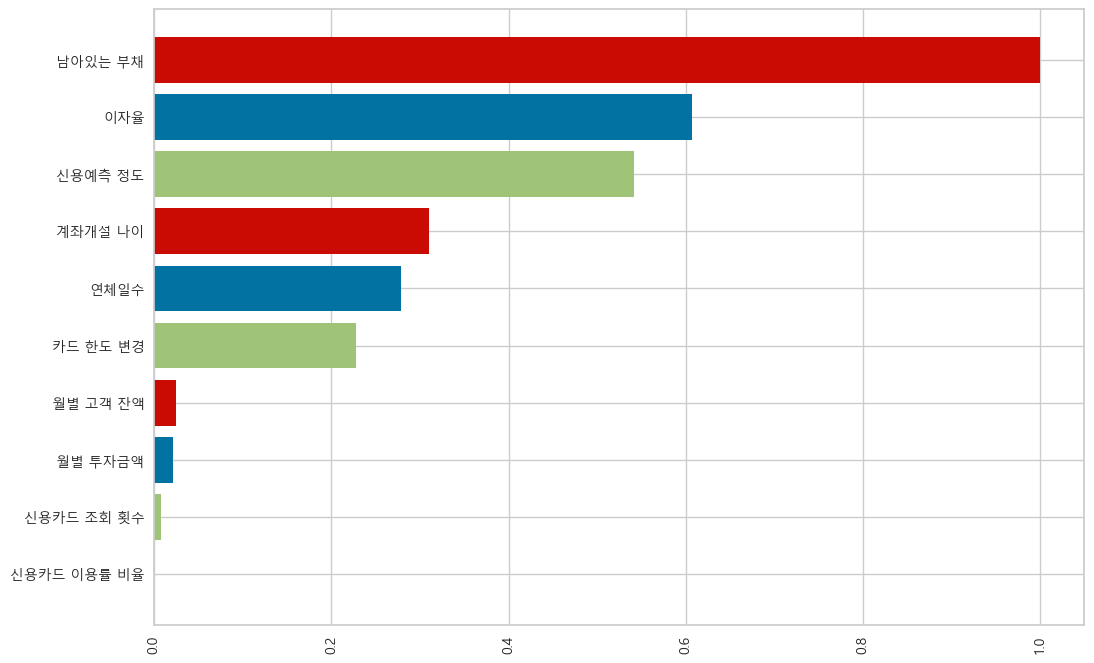

In [78]:
rf_model = joblib.load("./model/rf_best_model.h5")

plt.figure(figsize=(12, 8))

# XGBoost 모델의 feature_importances_를 얻습니다.
importances = rf_model.feature_importances_

# 인덱스를 기준으로 내림차순으로 정렬합니다.
sorted_indices = np.argsort(importances)[::-1]

# 정렬된 순서에 맞게 컬럼 이름을 배열로 얻습니다.
sorted_columns = np.array(x_valid_drop.columns)[sorted_indices]

# 정렬된 순서에 맞게 중요도를 배열로 얻습니다.
sorted_importances = importances[sorted_indices]

# 상위 10개의 특성과 중요도를 추출합니다.
top_n = 10
top_n_columns = sorted_columns[:top_n][::-1]
top_n_importances = sorted_importances[:top_n][::-1]

# MinMaxScaler를 사용하여 중요도를 0과 1 사이로 스케일링합니다.
scaler = MinMaxScaler()
scaled_importances = scaler.fit_transform(top_n_importances.reshape(-1, 1)).flatten()

# 막대 그래프를 그립니다.
plt.barh(top_n_columns, scaled_importances, color=['r', 'g', 'b'])
plt.xticks(rotation=90)
plt.show()

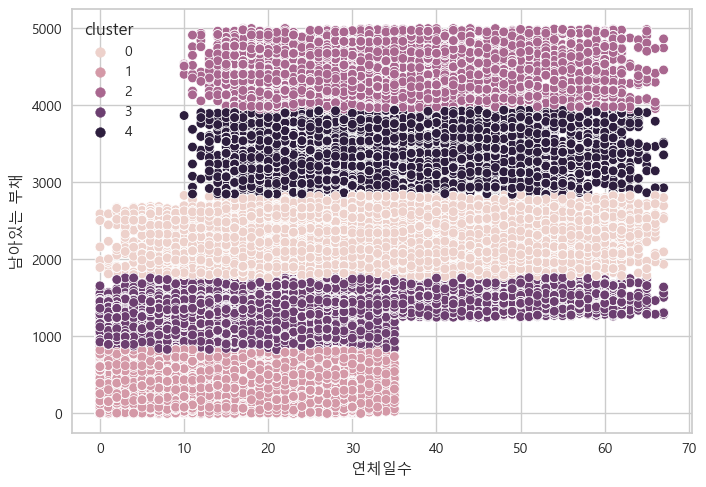

In [79]:
kmeans = KMeans(n_clusters=5, random_state=13)
clusters = kmeans.fit(df[['남아있는 부채', '이자율', '신용예측 정도', '계좌개설 나이', '연체일수', '카드 한도 변경']])


df['cluster'] = clusters.labels_

axs = plt.subplots()
axs = sns.scatterplot(data=df, x='연체일수', y='남아있는 부채', hue='cluster')

## 46세 미만

In [80]:
cat_model = joblib.load("./model_list/cat_best_model_for.h5")
rf_model = joblib.load("./model_list/rf_best_model_46re_under.h5")
lg_model = joblib.load("./model_list/lgbm_best_model_under46.h5")

df_model = pd.read_csv("./Dataset/df_for.csv")

x = df_model.drop(columns=["신용등급", '연령대'])
y = df_model['신용등급']

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=13)

x_valid_drop = x_valid.drop(columns="고객ID")

le = LabelEncoder()

y_valid_le = le.fit_transform(y_valid)

st = StandardScaler()
x_valid_drop_scale = st.fit_transform(x_valid_drop)

result_score = []
model_list = ["lg", " rf", "cat"]

models = [lg_model] 
for model in models:
    predictions = model.predict(x_valid_drop)
    result = accuracy_score(y_valid_le, predictions)
    result_score.append(result)

    
models = [rf_model] 
for model in models:
    predictions = model.predict(x_valid_drop)
    result = accuracy_score(y_valid, predictions)
    result_score.append(result)

    
predictions = cat_model.predict(x_valid)
result = accuracy_score(y_valid, predictions)
result_score.append(result)

for model_name, model_score in zip(model_list, result_score):
    print(model_name, ":",model_score)

weights = [0.2, 0.4, 0.4]


model1_proba = lg_model.predict_proba(x_valid_drop) * weights[0]
model2_proba = rf_model.predict_proba(x_valid_drop) * weights[1]
model3_proba = cat_model.predict_proba(x_valid) * weights[2]

sum_probas = np.array(model1_proba) + np.array(model2_proba) + np.array(model3_proba)
avg_probas = sum_probas / 3

# 평균 확률이 가장 큰 라벨을 최종 예측으로 선택합니다.
final_predictions = np.argmax(avg_probas, axis=1)

print(accuracy_score(y_valid_le, final_predictions))

print(confusion_matrix(y_valid_le, final_predictions))

print(classification_report(y_valid_le, final_predictions))

lg : 0.8297748220744371
 rf : 0.8390502858476258
cat : 0.8363084820907712
0.8457006183642516
[[2243    2  402]
 [   1 4942  493]
 [ 550 1197 7312]]
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      2647
           1       0.80      0.91      0.85      5436
           2       0.89      0.81      0.85      9059

    accuracy                           0.85     17142
   macro avg       0.83      0.85      0.84     17142
weighted avg       0.85      0.85      0.85     17142



In [81]:
cat_model = joblib.load("./model_list/cat_best_model_46.h5")
rf_model = joblib.load("./model_list/rf_best_model_46re_over.h5")
lg_model = joblib.load("./model_list/lgbm_best_model_upper46.h5")

df_model = pd.read_csv("./Dataset/df_for_46.csv")

x = df_model.drop(columns=["신용등급", '연령대'])
y = df_model['신용등급']

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=13)

x_valid_drop = x_valid.drop(columns="고객ID")

le = LabelEncoder()

y_valid_le = le.fit_transform(y_valid)

st = StandardScaler()
x_valid_drop_scale = st.fit_transform(x_valid_drop)

result_score = []
model_list = ["lg", " rf", "cat"]

models = [lg_model] 
for model in models:
    predictions = model.predict(x_valid_drop)
    result = accuracy_score(y_valid_le, predictions)
    result_score.append(result)

    
models = [rf_model] 
for model in models:
    predictions = model.predict(x_valid_drop)
    result = accuracy_score(y_valid, predictions)
    result_score.append(result)

    
predictions = cat_model.predict(x_valid)
result = accuracy_score(y_valid, predictions)
result_score.append(result)

for model_name, model_score in zip(model_list, result_score):
    print(model_name, ":",model_score)

weights = [0.2, 0.4, 0.4]


model1_proba = lg_model.predict_proba(x_valid_drop) * weights[0]
model2_proba = rf_model.predict_proba(x_valid_drop) * weights[1]
model3_proba = cat_model.predict_proba(x_valid) * weights[2]

sum_probas = np.array(model1_proba) + np.array(model2_proba) + np.array(model3_proba)
avg_probas = sum_probas / 3

# 평균 확률이 가장 큰 라벨을 최종 예측으로 선택합니다.
final_predictions = np.argmax(avg_probas, axis=1)

print(accuracy_score(y_valid_le, final_predictions))

print(confusion_matrix(y_valid_le, final_predictions))

print(classification_report(y_valid_le, final_predictions))

lg : 0.8293109478838755
 rf : 0.826512766701644
cat : 0.862889122070654
0.8534452605806226
[[ 839    0  101]
 [   0  307   79]
 [ 170   69 1294]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       940
           1       0.82      0.80      0.81       386
           2       0.88      0.84      0.86      1533

    accuracy                           0.85      2859
   macro avg       0.84      0.84      0.84      2859
weighted avg       0.85      0.85      0.85      2859

